In [1]:
# imports

from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from numpy.polynomial import Polynomial, polynomial
import time

# https://doi.org/10.1063/5.0019847 imports
import algorithm.generate_spectrum as gs
from algorithm.pixel_operations import choose_pixels, generate_combinations
from algorithm.temperature_functions import optimum_temperature
from algorithm.kfold import order_selection
from scipy.interpolate import splrep, splev, UnivariateSpline

# constants
h = 6.626e-34 # Planck's constant
c = 299792458 # Speed of light
k = 1.380649e-23 # Boltzmann constant
b = 2.89777e-3 # Wien's displacement law constant

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Opening Data

### Importing Data

In [2]:
# opening the raw data from its ENVI file and header
dark_ref = envi.open('graphite-rod/darkReference.hdr', 'graphite-rod/darkReference.raw')
white_ref = envi.open('graphite-rod/whiteReference.hdr', 'graphite-rod/whiteReference.raw')
data_ref = envi.open('graphite-rod/raw.hdr', 'graphite-rod/raw.raw')
print(type(data_ref))
print()
print(data_ref)

<class 'spectral.io.bilfile.BilFile'>

	Data Source:   './graphite-rod/raw.raw'
	# Rows:            719
	# Samples:        1600
	# Bands:           371
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16


In [3]:
# converting the data to a tensor as a NumPy array
white_tensor = np.array(white_ref.load())
dark_tensor = np.array(dark_ref.load())
data_tensor = np.array(data_ref.load())
print(type(data_tensor))
shape = data_tensor.shape
print(f"Tensor dimensions = {shape}")
print()
print(data_tensor)

<class 'numpy.ndarray'>
Tensor dimensions = (719, 1600, 371)

[[[ 374.  397.  491. ... 2258. 2244. 2355.]
  [ 374.  397.  491. ... 2255. 2140. 2115.]
  [ 409.  442.  494. ... 2282. 2251. 2087.]
  ...
  [ 121.   92.  113. ...  317.  265.  260.]
  [ 126.  124.  128. ...  243.  267.  222.]
  [ 114.  132.  120. ...  295.  275.  228.]]

 [[ 386.  447.  513. ... 2391. 2234. 2105.]
  [ 386.  447.  513. ... 2321. 2241. 2213.]
  [ 441.  473.  475. ... 2293. 2217. 2195.]
  ...
  [ 125.  127.  116. ...  276.  283.  283.]
  [ 126.  153.  125. ...  261.  292.  321.]
  [ 110.  133.  129. ...  295.  308.  265.]]

 [[ 395.  400.  539. ... 2178. 2240. 2222.]
  [ 395.  400.  539. ... 2263. 2216. 2242.]
  [ 353.  437.  453. ... 2299. 2181. 2180.]
  ...
  [ 144.  143.  118. ...  296.  317.  288.]
  [ 121.   93.  134. ...  310.  271.  243.]
  [ 101.  112.  144. ...  246.  288.  328.]]

 ...

 [[ 413.  481.  434. ... 2268. 2195. 2300.]
  [ 413.  481.  434. ... 2330. 2181. 2283.]
  [ 391.  488.  443. ... 224

/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

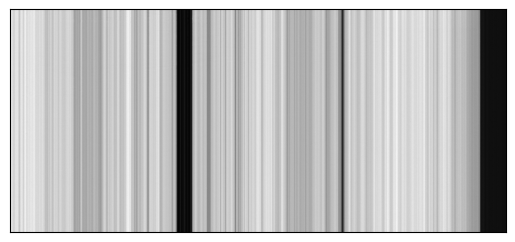

In [4]:
# correcting tensor with references and displaying tensor as an image
corrected_data = np.divide(
    np.subtract(data_tensor, dark_tensor),
    np.subtract(white_tensor, dark_tensor))
plt.figure()
imshow(corrected_data, (100,100,100))
plt.xticks([])
plt.yticks([])
plt.show()

<Figure size 640x480 with 0 Axes>

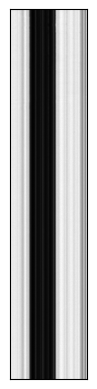

In [5]:
plt.figure()
imshow(corrected_data[:,500:650,:], (100,100,100))
plt.xticks([])
plt.yticks([])
plt.show()

<Figure size 640x480 with 0 Axes>

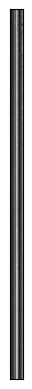

In [6]:
plt.figure()
imshow(corrected_data[:,550:575,:], (100,100,100))
plt.xticks([])
plt.yticks([])
plt.show()

## Parsing HDR for Bands

In [7]:
# reading hdr file
file = open("raw.hdr", 'r')
text = file.read()
print(text)

ENVI
description = {[HEADWALL Hyperspec III]}
samples = 1600
lines = 1562
bands = 371
header offset = 0
file type = ENVI Standard
data type = 12
interleave = bil
sensor type = Unknown
default bands = {191,86,50}
byte order = 0
wavelength units = nm
wavelength = {
399.471
,401.098
,402.725
,404.351
,405.978
,407.605
,409.232
,410.858
,412.485
,414.112
,415.738
,417.365
,418.992
,420.619
,422.245
,423.872
,425.499
,427.126
,428.752
,430.379
,432.006
,433.633
,435.259
,436.886
,438.513
,440.14
,441.766
,443.393
,445.02
,446.647
,448.273
,449.9
,451.527
,453.153
,454.78
,456.407
,458.034
,459.66
,461.287
,462.914
,464.541
,466.167
,467.794
,469.421
,471.048
,472.674
,474.301
,475.928
,477.555
,479.181
,480.808
,482.435
,484.062
,485.688
,487.315
,488.942
,490.569
,492.195
,493.822
,495.449
,497.075
,498.702
,500.329
,501.956
,503.582
,505.209
,506.836
,508.463
,510.089
,511.716
,513.343
,514.97
,516.596
,518.223
,519.85
,521.477
,523.103
,524.73
,526.357
,527.984
,529.61
,531.237
,532.864


In [8]:
# parsing for wavelength values and units

start_id = "\nwavelength = {\n"
start_index = text.find(start_id) + len(start_id)
end_id = "\n}\n;AOI height"
end_index = text.find(end_id)
wavelengths = text[start_index:end_index]
wavelengths_arr = np.array(wavelengths.split("\n,"), dtype="float32")

units_id = "wavelength units = "
units_index = text.find(units_id) + len(units_id)
units = text[units_index:text.find(start_id)]
print(f"Units = {units}")
print(f"Number wavelengths = {len(wavelengths_arr)}")
print(f"Wavelengths: {wavelengths_arr}")

Units = nm
Number wavelengths = 371
Wavelengths: [ 399.471  401.098  402.725  404.351  405.978  407.605  409.232  410.858
  412.485  414.112  415.738  417.365  418.992  420.619  422.245  423.872
  425.499  427.126  428.752  430.379  432.006  433.633  435.259  436.886
  438.513  440.14   441.766  443.393  445.02   446.647  448.273  449.9
  451.527  453.153  454.78   456.407  458.034  459.66   461.287  462.914
  464.541  466.167  467.794  469.421  471.048  472.674  474.301  475.928
  477.555  479.181  480.808  482.435  484.062  485.688  487.315  488.942
  490.569  492.195  493.822  495.449  497.075  498.702  500.329  501.956
  503.582  505.209  506.836  508.463  510.089  511.716  513.343  514.97
  516.596  518.223  519.85   521.477  523.103  524.73   526.357  527.984
  529.61   531.237  532.864  534.491  536.117  537.744  539.371  540.997
  542.624  544.251  545.878  547.504  549.131  550.758  552.385  554.011
  555.638  557.265  558.892  560.518  562.145  563.772  565.399  567.025
  568

## Loading one row

In [9]:
print(corrected_data.shape)
print(corrected_data[:,0,:].shape)
print(corrected_data[:,0,:][0].shape)

(719, 1600, 371)
(719, 371)
(371,)


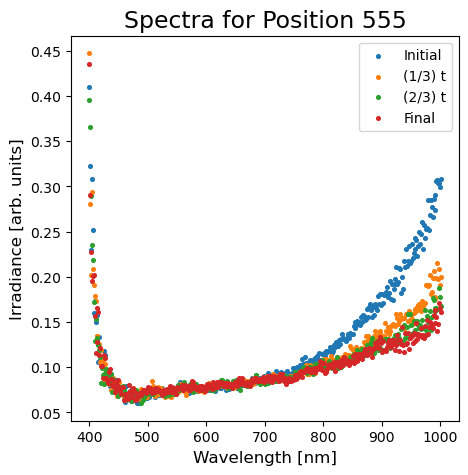

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(wavelengths_arr, corrected_data[:,555,:][0], s=7)
plt.scatter(wavelengths_arr, corrected_data[:,555,:][int(len(corrected_data[:,555,:][0]) * (1/3))], s=7)
plt.scatter(wavelengths_arr, corrected_data[:,555,:][int(len(corrected_data[:,555,:][0]) * (2/3))], s=7)
plt.scatter(wavelengths_arr, corrected_data[:,555,:][-1], s=7)
plt.title("Spectra for Position 555", fontsize=17)
plt.xlabel("Wavelength [nm]", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Irradiance [arb. units]", fontsize=12)
# plt.yticks([])
plt.legend(["Initial", "(1/3) t", "(2/3) t", "Final"], fontsize=10)
plt.show()

The infrared radiation decreases, indicating the rod cooling. The uptick for small wavelengths is strange -- is it an artifact of the camera, other light sources in the room, etc.?

### Blackbody at 700 C

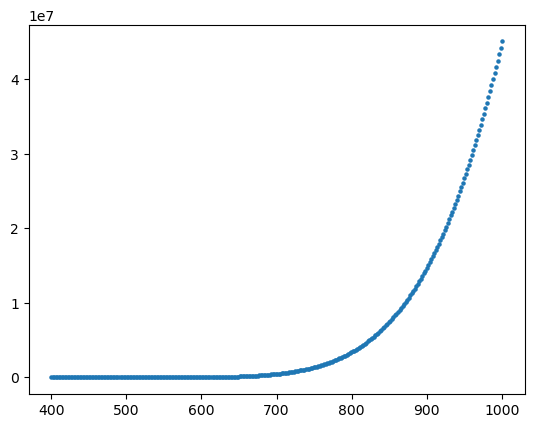

In [11]:
# l: wavelength, T: temperature, e: emissivity, offset: constant offset to account for stray light in the data
def blackbody(l, T, e, offset):
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

x = np.linspace(400e-9, 1000e-9, num=300)
y = np.array([blackbody(i, 700+273, 1, 0) for i in x])
plt.scatter(x*1e9, y, s=5)

# Pyrometry

In [12]:
def curve_fit(wl, data, intensity, params0):
    
    def residuals(params):
        result = []
        for i in range(len(wl)):
            Si = intensity(params, wl[i] * 1e-9)
            St = data[i]
            result.append(Si - St)
        return np.array(result)

    result = least_squares(residuals, params0)
    print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

    yfit = []
    for l in wl:
        yfit.append(intensity(result.x, l * 1e-9))
        
    plt.figure(figsize=(5,5))
    plt.scatter(wl, data, s=5)
    plt.scatter(wl, yfit, s=5)
    plt.title("Non-linear least squares regression", fontsize=15)
    plt.xlabel("Wavelength [nm]", fontsize=12)
    plt.xticks(fontsize=10)
    plt.ylabel("Intensity [arb. units]", fontsize=12)
    plt.yticks([])
    plt.legend(["Actual", "Fitted"], fontsize=10)
    plt.show()

### Initial

Optimal parameters: [ 3.50194291e-05 -6.86955285e+01  3.40735527e+07  8.64417634e-02
  7.50644591e+02]
Final Cost: 0.15836360862617344
Termination Status: 2


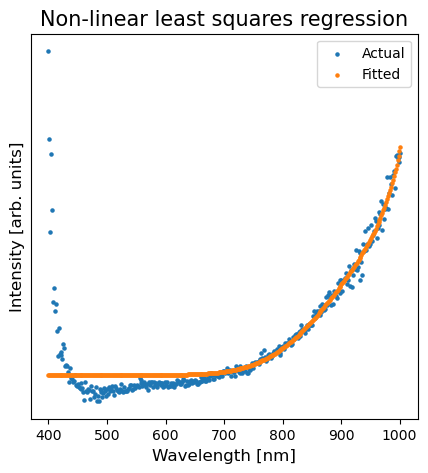

In [13]:
wl = wavelengths_arr
data = corrected_data[:,555,:][0]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

curve_fit(wl, data, intensity, params0)

### Removing lower wavelengths (focusing on infrared)
The idea is to neglect non-blackbody signals from the camera's imperfections or the rod not being the only light source in the room.

Optimal parameters: [ 2.47932858e-08 -4.82685145e-02  2.46504512e+04  7.39399362e-02
  1.08071179e+03]
Final Cost: 0.0047358401493975254
Termination Status: 2


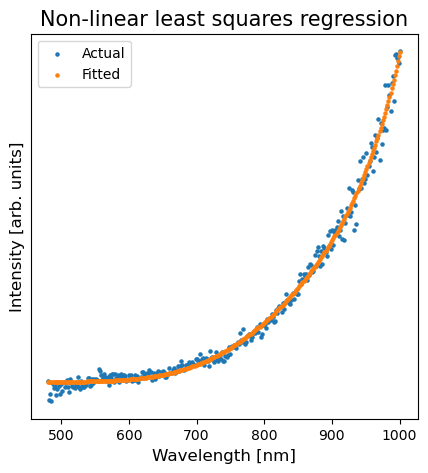

In [14]:
wl = wavelengths_arr[50:]
data = corrected_data[:,555,:][0][50:]

# params = [a0, a1, a2, offset, T]
params0 = [1, 1, 1, 0.1, 1000]
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 3.07339026e-07 -5.98368603e-01  2.99216446e+05  7.72602059e-02
  9.42893852e+02]
Final Cost: 0.003975441977393301
Termination Status: 2


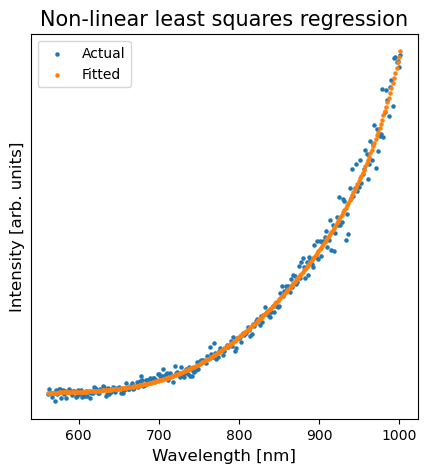

In [15]:
wl = wavelengths_arr[100:]
data = corrected_data[:,555,:][0][100:]

# params = [a0, a1, a2, offset, T]
params0 = [0.5, 0.5, 0.5, 0.1, 300]
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

curve_fit(wl, data, intensity, params0)

Optimal parameters: [ 1.21895151e-08 -2.40952604e-02  1.22920171e+04  2.49023969e-02
  1.19895178e+03]
Final Cost: 0.003400005459705463
Termination Status: 0


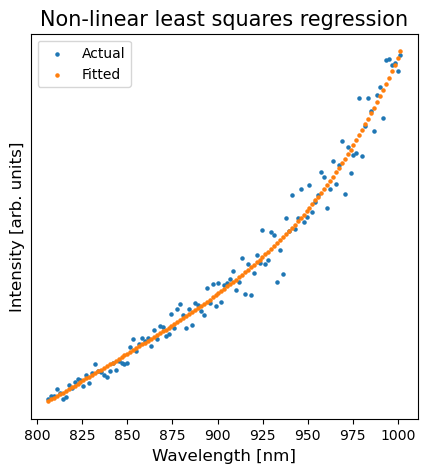

In [16]:
wl = wavelengths_arr[250:]
data = corrected_data[:,555,:][0][250:]

# params = [a0, a1, a2, offset, T]
params0 = np.array([1, 1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[4], e, params[3])

curve_fit(wl, data, intensity, params0)

### Decreasing Emissivity Order
If overfitting is the issue

Optimal parameters: [-1.40515826e-07  1.38289226e-01  1.22217806e-01  6.73788366e+01]
Final Cost: 0.7304085413262273
Termination Status: 2


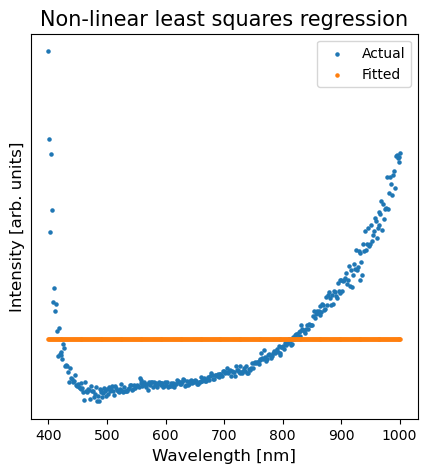

In [17]:
wl = wavelengths_arr
data = corrected_data[:,555,:][0]

# params = [a0, a1, offset, T]
params0 = np.array([1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody(l, params[3], e, params[2])

curve_fit(wl, data, intensity, params0)

Optimal parameters: [-3.19035533e-14  7.51659618e-05  7.53661737e-02  1.35431316e+03]
Final Cost: 0.0060005848550590355
Termination Status: 2


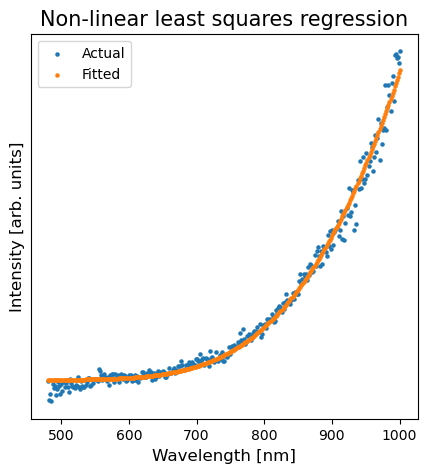

In [18]:
wl = wavelengths_arr[50:]
data = corrected_data[:,555,:][0][50:]

# params = [a0, a1, offset, T]
params0 = np.array([1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody(l, params[3], e, params[2])

curve_fit(wl, data, intensity, params0)

In [19]:
# wl = wavelengths_arr[50:]
# data = corrected_data[:,555,:][0][50:]

# # l: wavelength, T: temperature, e: emissivity
# def blackbody_offset(l, T, e, offset):
#     return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

# def residuals(params):
#     result = []
#     for i in range(len(wl)):
#         Si = intensity(params, wl[i] * 1e-9)
#         St = data[i]
#         result.append(Si - St)
#     return np.array(result)

# # params = [a0, a1, T, k]
# params0 = np.array([1, 1, 1000, 0.1])
# def intensity(params, l):
#     e = params[0] + (params[1] * l)
#     return blackbody_offset(l, params[2], e, params[3])

# result = least_squares(residuals, params0)
# print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

# yfit = []
# for l in wl:
#     yfit.append(intensity(result.x, l * 1e-9))
    
# plt.figure(figsize=(5,5))
# plt.scatter(wl, data, s=5)
# plt.scatter(wl, yfit, s=5)
# plt.title("Non-linear least squares regression", fontsize=15)
# plt.xlabel("Wavelength [nm]", fontsize=12)
# plt.xticks(fontsize=10)
# plt.ylabel("Intensity [arb. units]", fontsize=12)
# plt.yticks([])
# plt.legend(["Actual", "Fitted"], fontsize=10)
# plt.show()

In [20]:
# wl = wavelengths_arr[50:]
# data = corrected_data[:,555,:][0][50:]

# # l: wavelength, T: temperature, e: emissivity
# def blackbody_offset(l, T, e, offset):
#     return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

# def residuals(params):
#     result = []
#     for i in range(len(wl)):
#         Si = intensity(params, wl[i] * 1e-9)
#         St = data[i]
#         result.append(Si - St)
#     return np.array(result)

# # params = [a0, a1, T, k]
# params0 = np.array([1, 1000, 0.1])
# def intensity(params, l):
#     e = params[0]
#     return blackbody_offset(l, params[1], e, params[2])

# result = least_squares(residuals, params0)
# print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

# yfit = []
# for l in wl:
#     yfit.append(intensity(result.x, l * 1e-9))
    
# plt.figure(figsize=(5,5))
# plt.scatter(wl, data, s=5)
# plt.scatter(wl, yfit, s=5)
# plt.title("Non-linear least squares regression", fontsize=15)
# plt.xlabel("Wavelength [nm]", fontsize=12)
# plt.xticks(fontsize=10)
# plt.ylabel("Intensity [arb. units]", fontsize=12)
# plt.yticks([])
# plt.legend(["Actual", "Fitted"], fontsize=10)
# plt.show()

In [21]:
# wl = wavelengths_arr[50:]
# data = corrected_data[:,555,:][-1][50:]

# # l: wavelength, T: temperature, e: emissivity
# def blackbody_offset(l, T, e, offset):
#     return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

# def residuals(params):
#     result = []
#     for i in range(len(wl)):
#         Si = intensity(params, wl[i] * 1e-9)
#         St = data[i]
#         result.append(Si - St)
#     return np.array(result)

# # params = [a0, T, k]
# params0 = np.array([1, 1000, 0.1])
# def intensity(params, l):
#     e = params[0]
#     return blackbody_offset(l, params[1], e, params[2])

# result = least_squares(residuals, params0)
# print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

# yfit = []
# for l in wl:
#     yfit.append(intensity(result.x, l * 1e-9))
    
# plt.figure(figsize=(5,5))
# plt.scatter(wl, data, s=5)
# plt.scatter(wl, yfit, s=5)
# plt.title("Non-linear least squares regression", fontsize=15)
# plt.xlabel("Wavelength [nm]", fontsize=12)
# plt.xticks(fontsize=10)
# plt.ylabel("Intensity [arb. units]", fontsize=12)
# plt.yticks([])
# plt.legend(["Actual", "Fitted"], fontsize=10)
# plt.show()

Optimal parameters: [-5.21752987e-14  1.18383226e-04  7.98633317e-02  1.29776218e+03]
Final Cost: 0.004772050621903438
Termination Status: 2


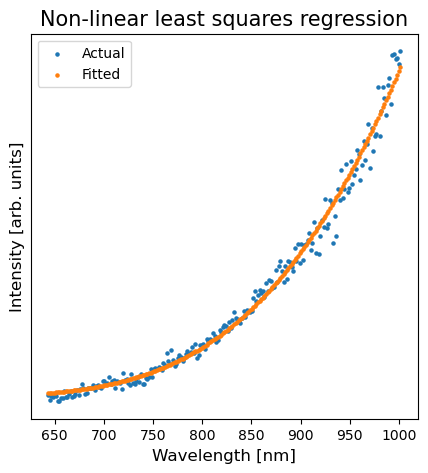

In [22]:
wl = wavelengths_arr[150:]
data = corrected_data[:,555,:][0][150:]

# params = [a0, a1, offset, T]
params0 = np.array([1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody(l, params[3], e, params[2])

curve_fit(wl, data, intensity, params0)

Optimal parameters: [-2.68774631e-13  6.59993350e-04  1.00098500e-01  1.11740969e+03]
Final Cost: 0.0038563605551316586
Termination Status: 2


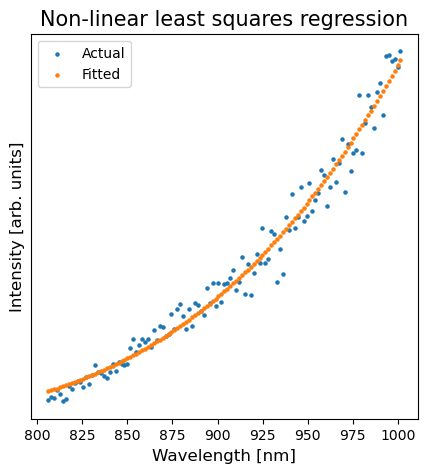

In [23]:
wl = wavelengths_arr[250:]
data = corrected_data[:,555,:][0][250:]

# params = [a0, a1, offset, T]
params0 = np.array([1, 1, 0.1, 1000])
def intensity(params, l):
    e = params[0] + (params[1] * l)
    return blackbody(l, params[3], e, params[2])

curve_fit(wl, data, intensity, params0)

### Increasing Emissivity Order

In [24]:
# wl = wavelengths_arr
# data = corrected_data[:,555,:][0]

# # params = [a0, a1, a2, a3, a4, T]
# params0 = [1, 1, 1, 1, 1, 1000]
# def intensity(params, l):
#     e = 0
#     for i in range(5):
#         e += params[i] * l**i
#     return blackbody(l, params[5], e)

# curve_fit(wl, data, intensity, params0)

In [25]:
# wl = wavelengths_arr[50:]
# data = corrected_data[:,555,:][0][50:]

# # params = [a0, a1, a2, a3, a4, T]
# params0 = [1, 1, 1, 1, 1, 1000]
# def intensity(params, l):
#     e = 0
#     for i in range(5):
#         e += params[i] * l**i
#     return blackbody(l, params[5], e)

# curve_fit(wl, data, intensity, params0)

In [26]:
# wl = wavelengths_arr[250:]
# data = corrected_data[:,555,:][0][250:]

# # params = [a0, a1, a2, a3, a4, T]
# params0 = [1, 1, 1, 1, 1, 1000]
# def intensity(params, l):
#     e = 0
#     for i in range(5):
#         e += params[i] * l**i
#     return blackbody(l, params[5], e)

# curve_fit(wl, data, intensity, params0)

## KFold (from https://github.com/pytaunay/multiwavelength-pyrometry)

### Exploring

In [27]:
# def kfold(wl_vec, I):
#     # Black and gray body
#     bb_eps = lambda wl,T: 1.0 * np.ones(len(wl))
#     # gr_eps = lambda wl,T: 0.5 * np.ones(len(wl))
    
#     # Parameters
#     Nwl = len(wl_vec)
    
#     pix_vec = np.linspace(0,len(wl_vec)-1,len(wl_vec))
#     pix_vec = np.array(pix_vec,dtype=np.int64)
        
#     # I_calc = gs.wien_approximation(wl_vec,T,eps2)
#     I_calc = I
#     noisy_data = np.copy(I_calc)
    
#     # Take the log of the data
    
#     log_noisy = np.log(noisy_data)
    
#     wl_vec_sub = np.copy(wl_vec)
#     log_med = np.copy(log_noisy)
#     pix_vec_sub = np.copy(pix_vec)
    
#     ### Fit a spline to access data easily
#     data_spl = splrep(wl_vec_sub,log_med)
    
#     pix_sub_vec = np.copy(pix_vec_sub)
#     filtered_data = np.copy(log_med)
    
    
#     #I_calc,noisy_data,filtered_data,data_spl,pix_sub_vec = gs.generate_data(
#     #        wl_vec,T,pix_vec,f_eps,el)
#     wl_sub_vec = wl_vec[pix_sub_vec]
    
#     ### Choose the order of the emissivity w/ k-fold
#     poly_order = order_selection(data_spl,
#                            pix_sub_vec,wl_vec,
#                            bb_eps)
    
#     ### Calculate the temperature using the whole dataset
#     # Pixel operations
#     chosen_pix = choose_pixels(pix_sub_vec,bin_method='average')
#     cmb_pix = generate_combinations(chosen_pix,pix_sub_vec)
    
#     # Compute the temperature
#     Tave, Tstd, Tmetric, sol = optimum_temperature(data_spl,cmb_pix,
#                                                 pix_sub_vec,wl_vec,
#                                                 poly_order)
    
#     print(f"Average Temp. = {Tave}, St. Dev. = {Tstd}")
    
#     ### Reconstruct data
#     bb_reconstructed = gs.wien_approximation(wl_sub_vec,Tave,bb_eps)
#     #eps_vec_reconstructed = 10**filtered_data/bb_reconstructed
#     eps_vec_reconstructed = np.exp(filtered_data)/bb_reconstructed
#     # Since we get epsilon from the filtered data, "reconstructed_data" will be
#     # exactly like "filtered_data"
#     reconstructed_data = bb_reconstructed * eps_vec_reconstructed # exactly filtered   
    
#     # Alternative using the polynomial from optimization
#     reconstructed_alt = gs.wien_approximation(wl_sub_vec,Tave,bb_eps)
#     wl_min = np.min(wl_sub_vec)
#     wl_max = np.max(wl_sub_vec)
    
#     if poly_order > 0:
#         cheb = Polynomial(sol.x,[wl_min,wl_max])
#         eps_vec = polynomial.polyval(wl_sub_vec,cheb.coef)
        
#     else:
#         eps_ave = np.average(eps_vec_reconstructed)
#         eps_vec = eps_ave * np.ones(len(wl_sub_vec))
        
#     reconstructed_alt *= eps_vec
    
    
#     #### Plots
#     fig, ax = plt.subplots(2,1)
#     ax[0].semilogy(wl_vec,noisy_data, linewidth=5)
#     ax[0].semilogy(wl_sub_vec,reconstructed_data, linewidth=3)
#     ax[0].semilogy(wl_vec, I, linewidth=1)
    
#     # ax[1].plot(wl_vec,eps2(wl_vec,T))
#     ax[1].plot(wl_sub_vec,eps_vec_reconstructed)
    
#     return Tave, Tstd

In [28]:
# _ = kfold(wavelengths_arr, corrected_data[:,555,:][0])

In [29]:
# _ = kfold(wavelengths_arr[50:], corrected_data[:,55,:][0][50:])

In [30]:
# _ = kfold(wavelengths_arr[150:], corrected_data[:,55,:][0][150:])

In [31]:
# _ = kfold(wavelengths_arr[250:], corrected_data[:,55,:][0][250:])

In [32]:
# _ = kfold(wavelengths_arr, corrected_data[:,555,:][-1])

In [33]:
# _ = kfold(wavelengths_arr[50:], corrected_data[:,555,:][-1][50:])

In [34]:
# _ = kfold(wavelengths_arr[150:], corrected_data[:,555,:][-1][150:])

In [35]:
# _ = kfold(wavelengths_arr[250:], corrected_data[:,555,:][-1][250:])

In [36]:
# _ = kfold(wavelengths_arr[275:], corrected_data[:,555,:][-1][275:])

In [37]:
# _ = kfold(wavelengths_arr[290:], corrected_data[:,555,:][-1][290:])

In [38]:
# _ = kfold(wavelengths_arr[300:], corrected_data[:,555,:][-1][300:])

### Temp based on points used

In [39]:
# wavelengths_arr[300]

In [40]:
# indices = np.arange(0, len(wavelengths_arr), 50)
# ave, std = [], []
# ti = time.time()
# for index in indices:
#     print(f"Index = {index}")
#     Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][0][index:])
#     ave.append(Tave), std.append(Tstd)
# tf = time.time()
# print(f"Time = {tf - ti} seconds")

In [41]:
# Ttop, Tbot = [], []
# for i in range(len(ave)):
#     Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

# plt.figure(figsize=(5,5))
# plt.title("Initial Frame", fontsize=15)
# plt.xlabel("Starting Index (Out of 371)", fontsize=12)
# plt.ylabel("Temperature [K]", fontsize=12)

# plt.plot(indices, ave, color="blue")
# plt.scatter(indices, ave, color="blue")
# plt.plot(indices, Ttop, color="blue", alpha=0.25)
# # plt.scatter(indices, Ttop, color="blue")
# plt.plot(indices, Tbot, color="blue", alpha=0.25)
# # plt.scatter(indices, Tbot, color="blue")
# plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

# plt.show()

In [42]:
# indices = np.arange(0, len(wavelengths_arr), 50)
# ave, std = [], []
# ti = time.time()
# for index in indices:
#     print(f"Index = {index}")
#     Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][-1][index:])
#     ave.append(Tave), std.append(Tstd)
# tf = time.time()
# print(f"Time = {tf - ti} seconds")

In [43]:
# Ttop, Tbot = [], []
# for i in range(len(ave)):
#     Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

# plt.figure(figsize=(5,5))
# plt.title("Final Frame", fontsize=15)
# plt.xlabel("Starting Index (Out of 371)", fontsize=12)
# plt.ylabel("Temperature [K]", fontsize=12)

# plt.plot(indices, ave, color="blue")
# plt.scatter(indices, ave, color="blue")
# plt.plot(indices, Ttop, color="blue", alpha=0.25)
# # plt.scatter(indices, Ttop, color="blue")
# plt.plot(indices, Tbot, color="blue", alpha=0.25)
# # plt.scatter(indices, Tbot, color="blue")
# plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

# plt.show()

In [44]:
# indices = np.arange(0, len(wavelengths_arr), 50)
# ave, std = [], []
# ti = time.time()
# for index in indices:
#     print(f"Index = {index}")
#     Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][0][index:])
#     ave.append(Tave), std.append(Tstd)
# tf = time.time()
# print(f"Time = {tf - ti} seconds")

In [45]:
# Ttop, Tbot = [], []
# for i in range(len(ave)):
#     Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

# plt.figure(figsize=(5,5))
# plt.title("Initial Frame, pix_slice = 7", fontsize=15)
# plt.xlabel("Starting Index (Out of 371)", fontsize=12)
# plt.ylabel("Temperature [K]", fontsize=12)

# plt.plot(indices, ave, color="blue")
# plt.scatter(indices, ave, color="blue")
# plt.plot(indices, Ttop, color="blue", alpha=0.25)
# # plt.scatter(indices, Ttop, color="blue")
# plt.plot(indices, Tbot, color="blue", alpha=0.25)
# # plt.scatter(indices, Tbot, color="blue")
# plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

# plt.show()

In [46]:
# indices = np.arange(0, len(wavelengths_arr), 50)
# ave, std = [], []
# ti = time.time()
# for index in indices:
#     print(f"Index = {index}")
#     Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][-1][index:])
#     ave.append(Tave), std.append(Tstd)
# tf = time.time()
# print(f"Time = {tf - ti} seconds")

In [47]:
# Ttop, Tbot = [], []
# for i in range(len(ave)):
#     Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

# plt.figure(figsize=(5,5))
# plt.title("Final Frame, pix_slice = 7", fontsize=15)
# plt.xlabel("Starting Index (Out of 371)", fontsize=12)
# plt.ylabel("Temperature [K]", fontsize=12)

# plt.plot(indices, ave, color="blue")
# plt.scatter(indices, ave, color="blue")
# plt.plot(indices, Ttop, color="blue", alpha=0.25)
# # plt.scatter(indices, Ttop, color="blue")
# plt.plot(indices, Tbot, color="blue", alpha=0.25)
# # plt.scatter(indices, Tbot, color="blue")
# plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

# plt.show()

In [48]:
# indices = np.arange(0, len(wavelengths_arr), 50)
# ave, std = [], []
# ti = time.time()
# for index in indices:
#     print(f"Index = {index}")
#     Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][0][index:])
#     ave.append(Tave), std.append(Tstd)
# tf = time.time()
# print(f"Time = {tf - ti} seconds")

In [49]:
# Ttop, Tbot = [], []
# for i in range(len(ave)):
#     Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

# plt.figure(figsize=(5,5))
# plt.title("Initial Frame, pix_slice = 1", fontsize=15)
# plt.xlabel("Starting Index (Out of 371)", fontsize=12)
# plt.ylabel("Temperature [K]", fontsize=12)

# plt.plot(indices, ave, color="blue")
# plt.scatter(indices, ave, color="blue")
# plt.plot(indices, Ttop, color="blue", alpha=0.25)
# # plt.scatter(indices, Ttop, color="blue")
# plt.plot(indices, Tbot, color="blue", alpha=0.25)
# # plt.scatter(indices, Tbot, color="blue")
# plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

# plt.show()

In [50]:
# indices = np.arange(0, len(wavelengths_arr), 50)
# ave, std = [], []
# ti = time.time()
# for index in indices:
#     print(f"Index = {index}")
#     Tave, Tstd = kfold(wavelengths_arr[index:], corrected_data[:,555,:][-1][index:])
#     ave.append(Tave), std.append(Tstd)
# tf = time.time()
# print(f"Time = {tf - ti} seconds")

In [51]:
# Ttop, Tbot = [], []
# for i in range(len(ave)):
#     Ttop.append(ave[i] + std[i]), Tbot.append(ave[i] - std[i])

# plt.figure(figsize=(5,5))
# plt.title("Final Frame, pix_slice = 1", fontsize=15)
# plt.xlabel("Starting Index (Out of 371)", fontsize=12)
# plt.ylabel("Temperature [K]", fontsize=12)

# plt.plot(indices, ave, color="blue")
# plt.scatter(indices, ave, color="blue")
# plt.plot(indices, Ttop, color="blue", alpha=0.25)
# # plt.scatter(indices, Ttop, color="blue")
# plt.plot(indices, Tbot, color="blue", alpha=0.25)
# # plt.scatter(indices, Tbot, color="blue")
# plt.fill_between(indices, Tbot, Ttop, color="blue", alpha=0.2)

# plt.show()

It is strange that the temperature predictions aren't able to identify that the rod cools down from the initial frame to the final frame.

These plots make me think that there are some artifacts in the spectrum through the visible range that are making the spectrum resemble higher temperature than it is. One thing I would like to try is getting the spectrum for a temperature at which the peak wavelengths is within the camera's range to see if this is consistent.